## Finding Fourier Coefficients

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import nquad
import auxfunctions as aux

# Parameters
a = 3.66
b = 1.75
c = 0.45
Nx = 256  # Number of sample points in x
Ny = 256  # Number of sample points in y
Nz = 16   # Number of sample points in z
truncation = 16

def Integrad1(x, y):
    return 0.15 * aux.cyc_perturb(x, y)

def Integrad2(x, y):
    return -0.6 * aux.cyc_perturb(x + 1, y)

# Integrate the boundary functions to enforce solvability criterion
If, _ = nquad(Integrad1, [[-a, a], [-b, b]])
Ig, _ = nquad(Integrad2, [[-a, a], [-b, b]])

# Create a grid of points in the domain
x = np.linspace(-a, a, Nx)
y = np.linspace(-b, b, Ny)
X, Y = np.meshgrid(x, y)

# Evaluate the function on the grid
F = 0.15 * aux.cyc_perturb(X, Y) - If / (4 * a * b)
G = -0.6 * aux.cyc_perturb(X + 1, Y) - Ig / (4 * a * b)

# Apply FFT
F_fft = np.fft.rfft2(F)
G_fft = np.fft.rfft2(G)

# Initialize arrays for reconstructed functions
F_reconstructed = np.zeros_like(F, dtype=np.complex128)
G_reconstructed = np.zeros_like(G, dtype=np.complex128)

# Initialize lists to store coefficients
F_coefficients = []
G_coefficients = []

# Reconstruct using the specified number of coefficients
for kx in range(-truncation, truncation + 1):
    for ky in range(truncation + 1):  # Keeping ky positive as rfft2's last axis is half-sized
        # Calculate the correct indices for kx
        kx_index = kx if kx >= 0 else Nx + kx
        # Calculate exponential terms for each dimension
        exp_x = np.exp(1j * np.pi * kx * (x[:, None] + a) / a)
        exp_y = np.exp(1j * np.pi * ky * (y[None, :] + b) / b)
        # Apply the FFT coefficient to the exponential terms
        # Note: For negative kx, we need to use the complex conjugate of the positive counterpart
        # This is inherently handled for the 'y' dimension by the nature of the real-to-complex FFT
        F_coefficient = 2 * F_fft[kx_index, ky] / (Nx * Ny)
        G_coefficient = 2 * G_fft[kx_index, ky] / (Nx * Ny)
        F_reconstructed += F_coefficient * exp_x * exp_y
        G_reconstructed += G_coefficient * exp_x * exp_y
        # Store coefficients
        F_coefficients.append([kx, ky, F_coefficient])
        G_coefficients.append([kx, ky, G_coefficient])

# Convert lists to dictionaries for efficient merging
# Key: (n, m), Value: coefficient
f_dict = {(f[0], f[1]): f[2] for f in F_coefficients}
g_dict = {(g[0], g[1]): g[2] for g in G_coefficients}

# Prepare combined list
combined_list = []
for key, f_val in f_dict.items():
    g_val = g_dict.get(key)
    if g_val is not None:
        combined_list.append([key[0], key[1], f_val, g_val])

# Convert to NumPy array
Fourier_array = np.array(combined_list, dtype=object)

# Function to compute w
def compute_w(kx, ky, a, b):
    return np.pi * np.sqrt((kx/a)**2 + (ky/b)**2)

# Function to solve the linear system for C1 and C2
def solve_for_C1_C2(Fnm, Gnm, w, c):
    # Construct the matrix A and vector b for the system Ax = b
    A = np.array([[w, - w], [w * np.exp(w * c), - w * np.exp(- w * c)]])
    b = np.array([Fnm, Gnm])
    
    # Solve the system
    C = np.linalg.solve(A, b)
    return C[0], C[1]

# Initialize an empty list to store the results
coefficients = []

# Iterate over each row in the combined_array
for row in Fourier_array:
    kx, ky, Fnm, Gnm = row
    # Handle the special case where kx = ky = 0
    if kx == 0 and ky == 0:
        C1, C2 = 0 + 0j, 0 + 0j
    else:
        w = compute_w(kx, ky, a, b)
        C1, C2 = solve_for_C1_C2(Fnm, Gnm, w, c)
    coefficients.append([kx, ky, C1, C2])

# Convert the results to a NumPy array for easier handling and manipulation
Coefficients_array = np.array(coefficients, dtype=object)

# Implement the solution
def u(x, y, z, coefficients, a, b):
    """Calculate the spatial gradients of the solution."""
    u = 0
    for kx, ky, C1, C2 in coefficients:
        w = compute_w(kx, ky, a, b)
        term_x = np.exp(1j * np.pi * kx * (x[:, None] + a) / a)
        term_y = np.exp(1j * np.pi * ky * (y[None, :] + b) / b)
        u += term_x * term_y * (C1 * np.exp(w * z) + C2 * np.exp(-w * z))
    return u

# Implement gradient functions using direct computation
def grad_u(x, y, z, coefficients, a, b):
    """Calculate the spatial gradients of the solution."""
    grad_u = np.zeros((len(x), len(y), len(z)) + (3,), dtype=np.complex_)
    for kx, ky, C1, C2 in coefficients:
        w = compute_w(kx, ky, a, b)
        term_x = np.exp(1j * np.pi * kx * (x[:, None, None] + a) / a)
        term_y = np.exp(1j * np.pi * ky * (y[None, :, None] + b) / b)
        grad_u[:, :, :, 0] += (1j * np.pi * kx / a) * term_x * term_y * (C1 * np.exp(w * z[None, None, :]) + C2 * np.exp(-w * z[None, None, :]))  # du/dx
        grad_u[:, :, :, 1] += (1j * np.pi * ky / b) * term_x * term_y * (C1 * np.exp(w * z[None, None, :]) + C2 * np.exp(-w * z[None, None, :]))  # du/dy
        grad_u[:, :, :, 2] += term_x * term_y * w * (C1 * np.exp(w * z[None, None, :]) - C2 * np.exp(-w * z[None, None, :]))  # du/dz
    return grad_u

x1 = np.linspace(-a, a, Nx)
y1 = np.linspace(-b, b, Ny)
z1 = np.linspace(0, c, Nz)

# Evaluate basic state + u at z = 0 and z = c
u_z0 = grad_u(x1, y1, z1, Coefficients_array, a, b)[:, :, 0, 2]
u_zc = grad_u(x1, y1, z1, Coefficients_array, a, b)[:, :, -1, 2]

print(np.shape(u_z0))

# Plotting using contour plots
fig, axes = plt.subplots(2, 3, figsize=(14, 8))

# Original F contour
cf = axes[0, 0].contourf(X, Y, np.real(F), levels=20, cmap='viridis')
fig.colorbar(cf, ax=axes[0, 0])
axes[0, 0].set_title('Original F')

# Reconstructed F contour
cf = axes[0, 1].contourf(X, Y, np.real(F_reconstructed), levels=20, cmap='viridis')
fig.colorbar(cf, ax=axes[0, 1])
axes[0, 1].set_title('Reconstructed F')

# Derivative of u at z=0 contour
cf = axes[0, 2].contourf(X, Y, np.real(u_z0), levels=20, cmap='viridis')
fig.colorbar(cf, ax=axes[0, 2])
axes[0, 2].set_title('Derivative of u at z=0')

# Original G contour
cf = axes[1, 0].contourf(X, Y, np.real(G), levels=20, cmap='viridis')
fig.colorbar(cf, ax=axes[1, 0])
axes[1, 0].set_title('Original G')

# Reconstructed G contour
cf = axes[1, 1].contourf(X, Y, np.real(G_reconstructed), levels=20, cmap='viridis')
fig.colorbar(cf, ax=axes[1, 1])
axes[1, 1].set_title('Reconstructed G')

# Derivative of u at z=c contour
cf = axes[1, 2].contourf(X, Y, np.real(u_zc), levels=20, cmap='viridis')
fig.colorbar(cf, ax=axes[1, 2])
axes[1, 2].set_title('Derivative of u at z=c')

plt.tight_layout()
plt.show()

## Construct Cyclone Initial Condition Using FEniCs

In [ ]:
# Construct Cyclone Initial Condition

from dolfin import *
import numpy as np
import auxfunctions as aux

def create_cyc_initial(N, box, A, PeriodicX, PeriodicY, PeriodicZ):
    """
    Create an initial condition for an isolated cyclone with or without shear.

    Parameters:
        N (int): The number of seeds.
        box (list): The fluid domain of the model [xmin, ymin, zmin, xmax, ymax, zmax].
        A (float): Shear wind factor (0 or 0.1).
        PeriodicX (bool): Periodic boundary condition in the X-direction.
        PeriodicY (bool): Periodic boundary condition in the Y-direction.
        PeriodicZ (bool): Periodic boundary condition in the Z-direction.

    Returns:
        numpy.ndarray: The initial seed positions.

    Raises:
        ValueError: If N does not allow generating a valid lattice.
    """
    # Compute the cubic root of the number of seeds to later check that we can generate a valid lattice
    croot = round(N ** (1 / 3))

    if N == croot ** 3:
        # Create coordinate arrays for each dimension
        col_0 = np.linspace(box[0], box[3], croot)
        col_1 = np.linspace(box[1], box[4], croot)
        col_2 = np.linspace(box[2], box[5], croot)

        # Create a 3D lattice using meshgrid
        Col_0, Col_1, Col_2 = np.meshgrid(col_0, col_1, col_2)

        # Combine the coordinate arrays into a single matrix
        matrix = np.column_stack((Col_0.flatten(), Col_1.flatten(), Col_2.flatten()))

    else:
        raise ValueError('Invalid number of seeds, N must allow generating a valid lattice')

    # Solve Laplace's equation for the perturbation
    a, b, c = box[3], box[4], box[5]

    # Sub domain for Periodic boundary condition
    class PeriodicBoundary(SubDomain):
        """
        Define a periodic boundary condition for a specified rectangular domain.

        This class represents a periodic boundary condition in three dimensions (x, y, z). It allows points on the left (x = -a)
        and bottom (y = -b) sides to be mapped to the right (x = a) and top (y = b) sides of the rectangular domain, respectively.

        Parameters:
            a (float): The domain's half-length in the x-direction.
            b (float): The domain's half-length in the y-direction.

        Methods:
            inside(self, x, on_boundary):
                Determine if a point is inside the periodic boundary.

                Parameters:
                    x (list): The coordinates of the point.
                    on_boundary (bool): Boolean indicating whether the point is on the boundary.

                Returns:
                    bool: True if the point is inside the periodic boundary, False otherwise.

            map(self, x, y):
                Map a point to the opposite side of the periodic boundary.

                Parameters:
                    x (list): The coordinates of the original point.
                    y (list): The coordinates of the mapped point.

                Returns:
                    None
        """
        # Points on the left (x = -a) and bottom (y = -b) are mapped to the right (x = a) and top (y = b)
        def inside(self, x, on_boundary):
            # Use near() to handle floating-point comparisons
            return bool((near(x[0], -a) or near(x[1], -b)) and on_boundary)

        # Map to the opposite side
        def map(self, x, y):
            if near(x[0], a):
                y[0] = x[0] - 2 * a
            else:
                y[0] = x[0]

            if near(x[1], b):
                y[1] = x[1] - 2 * b
            else:
                y[1] = x[1]

            y[2] = x[2]  # z-coordinate remains the same

    # Create mesh and finite elements and enforce periodic boundary conditions
    mesh = BoxMesh(Point(-a, -b, 0), Point(a, b, c), 32, 32, 32)
    V = FunctionSpace(mesh, "CG", 1, constrained_domain=PeriodicBoundary())

    # Sub domain for the Neumann boundary condition
    class Bottom(SubDomain):
        """
        Define a subdomain for the Neumann boundary condition at the bottom of the domain.

        This class represents a subdomain for applying the Neumann boundary condition at the bottom of a 3D domain.
        Points within a small tolerance of z = 0.0 are considered to be on this boundary.

        Methods:
            inside(self, x, on_boundary):
                Determine if a point is inside the bottom subdomain.

                Parameters:
                    x (list): The coordinates of the point.
                    on_boundary (bool): Boolean indicating whether the point is on the boundary.

                Returns:
                    bool: True if the point is inside the bottom subdomain, False otherwise.
        """
        def inside(self, x, on_boundary):
            return bool(near(x[2], 0.0) and on_boundary)

    class Top(SubDomain):
        """
        Define a subdomain for the Neumann boundary condition at the top of the domain.

        This class represents a subdomain for applying the Neumann boundary condition at the top of a 3D domain.
        Points within a small tolerance of z = c are considered to be on this boundary.

        Methods:
            inside(self, x, on_boundary):
                Determine if a point is inside the top subdomain.

                Parameters:
                    x (list): The coordinates of the point.
                    on_boundary (bool): Boolean indicating whether the point is on the boundary.

                Returns:
                    bool: True if the point is inside the top subdomain, False otherwise.
        """
        def inside(self, x, on_boundary):
            return bool(near(x[2], c) and on_boundary)

    # Initialize sub-domain instances
    bottom = Bottom()
    top = Top()

    # Initialize mesh function for boundary domains
    boundaries = MeshFunction("size_t", mesh, mesh.topology().dim()-1, 0)
    boundaries.set_all(0)
    bottom.mark(boundaries, 1)
    top.mark(boundaries, 2)

    # Define expressions for the Neumann conditions
    f_expression = Expression("- 0.6 * ( pow((1 + pow((x[0] + 1) / 0.5, 2) + pow(x[1] / 0.5, 2)), -1.5) - "
                              "0.5 * ( pow(1 + pow(x[0] / 0.5, 2) + pow(x[1] / 0.5, 2), -1.5) + "
                              "pow(1 + pow((x[0] + 2) / 0.5, 2) + pow(x[1] / 0.5, 2), -1.5) ) )", degree=3)  # f(x, y) at top
    g_expression = Expression("0.15 * ( pow(1 + pow(x[0] / 0.5, 2) + pow(x[1] / 0.5, 2), -1.5) - "
                              "0.5 * ( pow(1 + pow((x[0] - 1) / 0.5, 2) + pow(x[1] / 0.5, 2), -1.5) + "
                              "pow(1 + pow((x[0] + 1) / 0.5, 2) + pow(x[1] / 0.5, 2), -1.5) ) )", degree=3)  # g(x, y) at bottom

    # Define expression for Phi(x, y, z)
    phi_expression = Expression("(1 / 2) * (atan2(x[1], 1 + x[2]) - atan2(x[1], 1 - x[2])) - "
                                "0.12 * x[1] * x[2] - (1 / 2) * A * (pow(x[1], 2) - pow(x[2],2))", degree=2, A=A)  # Phi(x, y, z)

    # Define the variational problem
    u = TrialFunction(V)
    v = TestFunction(V)
    bform = dot(grad(u), grad(v)) * dx  # bilinear form

    # Set the Neumann Boundary Conditions
    ds = Measure("ds", subdomain_data = boundaries)
    L =  g_expression * v * ds(1) + f_expression * v * ds(2)  # linear form

    # Compute solution
    u = Function(V)
    solve(bform == L, u)

    # Sum the solution of Laplace for the perturbation to the base state
    # Create a non-periodic function space
    V_non_periodic = FunctionSpace(mesh, "CG", 1)
    Phi = Function(V_non_periodic)
    Phi.interpolate(phi_expression)

    # Project or interpolate u onto the non-periodic function space
    u_non_periodic = project(u, V_non_periodic)

    # Add Phi to u in the non-periodic space
    Phi_u = Function(V_non_periodic)
    Phi_u.vector()[:] = Phi.vector()[:] + u_non_periodic.vector()[:]

    # Define the function to compute the mapped lattice points
    def map_lattice_points(lattice_points, function):
        """
        Map lattice points using the gradient of a given function.
    
        This function takes a list of lattice points and maps them forward using the gradient of a provided function.
        It creates a vector function space for the gradient, evaluates the gradient at each lattice point, and maps the
        lattice points forward by the gradient to obtain new mapped points.
    
        Parameters:
            lattice_points (list of lists): A list of lattice points represented as [x, y, z] coordinates.
            function (Expression or Function): The function whose gradient is used for mapping.
    
        Returns:
            numpy.ndarray: An array of mapped points with the same shape as the input lattice_points.
        """
        mapped_points = []

        # Create a vector function space for the gradient
        V_grad = VectorFunctionSpace(mesh, "DG", 1)
        grad_function = project(grad(function), V_grad)

        for point in lattice_points:
            x, y, z = point

            # Create a FEniCS Point object
            fenics_point = Point(float(x), float(y), float(z))

            # Evaluate the gradient of Phi + u at the current lattice point
            gradient_phi_u = grad_function(fenics_point)

            # Map the lattice point forward by the gradient
            mapped_point = [x + gradient_phi_u[0], y + gradient_phi_u[1], z + gradient_phi_u[2]]

            mapped_points.append(mapped_point)

        return np.array(mapped_points)

    # Map the lattice points using the gradient of Phi + u
    Z = aux.get_remapped_seeds(box, map_lattice_points(matrix, Phi_u), PeriodicX, PeriodicY, PeriodicZ)

    return Z

## Code for Investigating if the Neumann Boundary Conditions have been Properly Applied in FEniCs

In [ ]:
from dolfin import *
import matplotlib.pyplot as plt
import numpy as np

# Compute the gradient of u
V_vec = VectorFunctionSpace(mesh, 'DG', 1)
grad_u = project(grad(u), V_vec)

# Function to extract and evaluate the z-component of the gradient
def evaluate_dudz_on_plane(z_value, X, Y):
    rows, cols = X.shape
    dudz_values = np.zeros((rows, cols))
    for i in range(rows):
        for j in range(cols):
            # Use X[i, j] and Y[i, j] to get the individual points
            p = Point(X[i, j], Y[i, j], z_value)
            dudz_values[i, j] = grad_u(p)[2]  # z-component of the gradient
    return dudz_values

# Create a regular 2D grid for the x-y plane
x = np.linspace(-a, a, 100)
y = np.linspace(-b, b, 100)
X, Y = np.meshgrid(x, y)

# Function to interpolate Phi_u on a specific z-plane
def interpolate_on_plane(z_value, X, Y):
    rows, cols = X.shape
    values = np.zeros((rows, cols))
    for i in range(rows):
        for j in range(cols):
            p = Point(X[i, j], Y[i, j], z_value)
            values[i, j] = Phi_u(p)
    return values

# Interpolate data on the z=0 and z=c planes
values_at_z0 = interpolate_on_plane(0, X, Y)
values_at_zc = interpolate_on_plane(c, X, Y)
# values_at_z0 = evaluate_dudz_on_plane(0, X, Y)
# values_at_zc = evaluate_dudz_on_plane(c, X, Y)

# Create contour plots with just the contour lines
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 15 contours for z=0 plane
contour1 = ax1.contour(X, Y, values_at_z0, levels=20)
fig.colorbar(contour1, ax=ax1)
ax1.set_title('Contour plot at z=0')
ax1.set_xlabel('x')
ax1.set_ylabel('y')

# Plot 15 contours for z=c plane
contour2 = ax2.contour(X, Y, values_at_zc, levels=20)
fig.colorbar(contour2, ax=ax2)
ax2.set_title(f'Contour plot at z={c}')
ax2.set_xlabel('x')
ax2.set_ylabel('y')

plt.show()

## Ensuring that the cyclone initial condition is being generated correctly

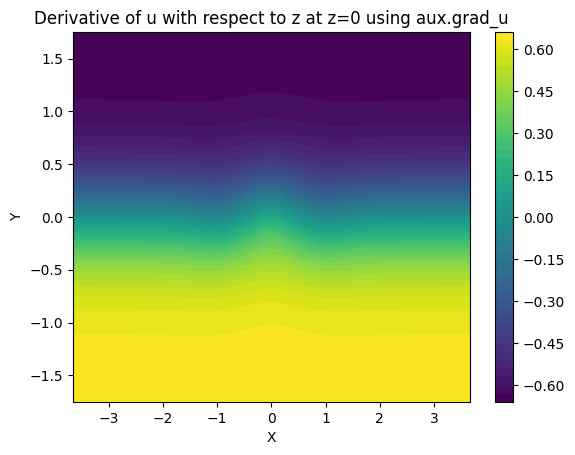

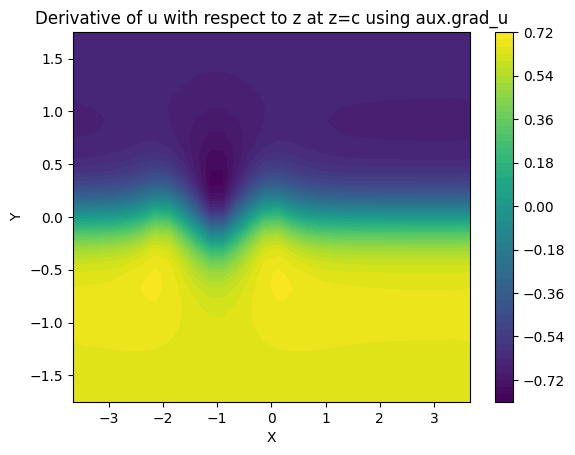

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import auxfunctions as aux

a, b, c = 3.66, 1.75, 0.45
box = [-a, -b, 0, a, b, c]
x, y, z = np.linspace(-a, a, 30), np.linspace(-b, b, 30), np.linspace(0, c, 30)
A = 0

# Calculate FFT coefficients based on cyclone perturbation functions
fourier_coefficients = aux.compute_fft_coefficients(box, 16)

# Solve for C1 and C2 coefficients using the linear system based on Laplace's equation
solution_coefficients = aux.compute_coefficients(box, fourier_coefficients)

def plot_dudz_contour(x, y, z, level, coefficients, a, b, title):
    """
    Plot the contour of the z-derivative of u at a given z-height.

    Parameters:
        x (np.ndarray): Array of x coordinates.
        y (np.ndarray): Array of y coordinates.
        Z (float): The z-height at which to evaluate the gradient.
        coefficients (list): Solution coefficients [kx, ky, C1, C2].
        a (float): Domain size in the x direction.
        b (float): Domain size in the y direction.
        title (str): Plot title.
    """
    # Set up mesh
    X, Y = np.meshgrid(x, y, indexing='ij')

    # Calculate du/dz using grad_u
    dudz_values = np.real(aux.grad_u(x[:, None, None], y[None, :, None], z[None, None, :], coefficients, a, b)).T 
    dPhidz_values = aux.grad_basic_state(x[:, None, None], y[None, :, None], z[None, None, :], 0)

    plt.figure()
    contour = plt.contourf(X, Y, dPhidz_values[:, :, level, 2] + dudz_values[2, level, :, :], levels=50, cmap='viridis')
    plt.colorbar(contour)
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

def plot_combined_contour(x, y, Z, coefficients, a, b, A, title):
    X, Y = np.meshgrid(x, y, indexing='ij')
    u_values = np.zeros(X.shape + (3,), dtype=np.float64)
    phi_values = np.zeros(X.shape + (3,), dtype=np.float64)

    # Loop over the grid and calculate the combined function value at each point
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            # Directly sum the basic state and u function values
            u_values[i, j] = np.real(aux.grad_u(X[i, j], Y[i, j], Z, coefficients, a, b)) 
            phi_values[i, j] = aux.grad_basic_state(X[i, j], Y[i, j], Z, A)
        print(i)

    sol = u_values.T[2, :, :] + phi_values[:, :, 2]

    # Plot the combined function values using a contour plot
    plt.figure()
    contour = plt.contourf(X, Y, sol, levels=50, cmap='viridis')
    plt.colorbar(contour)
    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

# # Assuming fourier_coefficients and solution_coefficients are computed as shown previously
plot_dudz_contour(x, y, z, 0, solution_coefficients, a, b, 'Derivative of u with respect to z at z=0 using aux.grad_u')
plot_dudz_contour(x, y, z, -1, solution_coefficients, a, b, 'Derivative of u with respect to z at z=c using aux.grad_u')
# plot_combined_contour(x, y, 0, solution_coefficients, a, b, A, 'Combined value at z=0')
# plot_combined_contour(x, y, c, solution_coefficients, a, b, A, 'Combined value at z=c')

# Understanding what der functinos of pysdot do

In [2]:
import numpy as np
from pysdot import OptimalTransport
from pysdot.domain_types import ConvexPolyhedraAssembly

box = [0, -0.5, 1, 0.5] # Fundamental Domain
Z = np.array([[0.25, 0], [0.5, 0]])
psi0 = np.zeros(shape = (2,))

#Constructs a domain to be passed to the laguerre functions
def make_domain(box, PeriodicX, PeriodicY):
    """
    Constructs a domain for the optimal transport problem.

    Parameters:
        box (list/tuple): Domain boundaries [xmin, ymin, zmin, xmax, ymax, zmax].
        PeriodicX, PeriodicY (bool): Periodicity flags for each axis.

    Returns:
        ConvexPolyhedraAssembly: Domain object for the optimal transport solver.
    """
    domain = ConvexPolyhedraAssembly()
    Lx, Ly = [box[i+2] - box[i] for i in range(2)]

    # Calculate the offset and size for each dimension based on periodicity
    size = [2 * Lx if PeriodicX else box[2], 
            2 * Ly if PeriodicY else box[3]]

    offset = [-Lx if PeriodicX else box[0], 
              -Ly if PeriodicY else box[1]]

    domain.add_box(offset, size)
    return domain

#Solve the Optimal transport problem and return the centroids and weights
def ot_solve(domain, Y, psi0, err_tol, PeriodicX, PeriodicY, box, solver = 'Petsc', debug = False):
    """
    Solves the optimal transport problem and returns centroids, weights, and cell masses.

    Parameters:
        domain (ConvexPolyhedraAssembly): Source domain of the optimal transport problem.
        Y (numpy.ndarray): Seed positions.
        psi0 (numpy.ndarray): Initial weight guesses.
        err_tol (float): Error tolerance for cell mass.
        PeriodicX, PeriodicY (bool): Periodicity flags.
        box (list/tuple): Domain boundaries.
        solver (str): Linear solver to use ('Petsc' or 'Scipy').
        debug (bool): Flag to enable debugging information.

    Returns:
        tuple: Centroids, optimal weights, and cell masses after optimization.
    """
    N = Y.shape[0]
    Lx, Ly = [abs(box[i+2] - box[i]) for i in range(2)]
    ot = OptimalTransport(positions=Y, weights=psi0, masses=Lx * Ly * np.ones(N) / N, domain=domain, linear_solver=solver)
    ot.set_stopping_criterion(err_tol, 'max delta masses')

    # Adding replications based on periodicity
    for x in range(-int(PeriodicX), int(PeriodicX) + 1):
        for y in range(-int(PeriodicY), int(PeriodicY) + 1):
            if x != 0 or y != 0:
                ot.pd.add_replication([Lx * x, Ly * y])

    premass = ot.get_masses() if debug else None
    ot.adjust_weights()
    psi = ot.get_weights()
    postmass = ot.pd.integrals()
    transportcost = ot.pd.second_order_moments()
    h = ot.pd.der_centroids_and_integrals_wrt_weight_and_positions()

    if debug:
        print('Difference in target and final mass', np.linalg.norm(premass - postmass) / np.linalg.norm(premass))

    return h

# Construct the domain for our test probelm
D = make_domain(box, False, False)

# Solve the optimal tranport problem
sol = ot_solve(D, Z, psi0, 1e-3, False, False, box)

print(sol)

TypeError: 'pybind_sdot_2d_double.DerResult' object is not subscriptable